**About** : This notebook is used to train detection models.

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [36]:
%matplotlib inline

In [2]:
cd ../src/

/workspace/kaggle_benetech/src


## Initialization

### Imports

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [4]:
import os
import cv2
import sys
import ast
import glob
import json
import yaml
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

In [173]:
from params import *
from util.plots import *
from inference.yolo import *

### Load data

In [6]:
df = pd.read_csv('../input/df_train.csv')
df_text = pd.read_csv('../input/texts.csv')
df_target = pd.read_csv('../input/y_train.csv')
df_elt = pd.read_csv('../input/elements.csv')

In [ ]:
df = df[~df['id'].isin(ANOMALIES)].reset_index(drop=True)

In [66]:
df_split = pd.read_csv('../input/df_split.csv')
df = df.merge(df_split)

In [259]:
class Config:
    selected_model = "yolo"
    bbox_format = "yolo"
    pred_format = "pascal_voc"

    weights = "/workspace/kaggle_benetech/logs/yolov7x-w6-/weights/best.pt"
    
    size = (640, 640)
#     size = (1024, 1024)
#     size = (1280, 1280)

    # NMS
    conf_thresh = 0.1 # 1  # 0.1
    max_per_img = 500
    min_per_img = 0
    iou_thresh = 0.5

    val_bs = 8
    device = "cuda"

In [260]:
model = retrieve_model(Config)

Fusing layers... 
IAuxDetect.fuse


### Predict
- IoU per class
- merge xticks and yticks (/labels)
- train without bars

In [261]:
df_val = df[df['split'] == "val"].reset_index(drop=True)
df_val['path'] = '../input/images/valid/' + df_val['id'] + '.jpg'
df_val['gt_path'] = '../input/labels/valid/' + df_val['id'] + '.txt'

In [263]:
CLASSES = [
    "dot",
    "line",
#     "vertical_bar",
#     "horizontal_bar",
    "scatter",
]

df_val = df_val[df_val['chart-type'].isin(CLASSES)].reset_index(drop=True)
# df_val = df_val[df_val['source'] == "extracted"].reset_index(drop=True)

In [264]:
transforms = get_transfos(size=Config.size)
dataset = InferenceDataset(df_val, transforms)

In [265]:
%%time
meter = predict(model, dataset, Config)

for i, p in enumerate(meter.preds):
    p.update_shape((df_val['img_h'][i], df_val['img_w'][i]))

CPU times: user 2.69 s, sys: 738 ms, total: 3.43 s
Wall time: 3.02 s


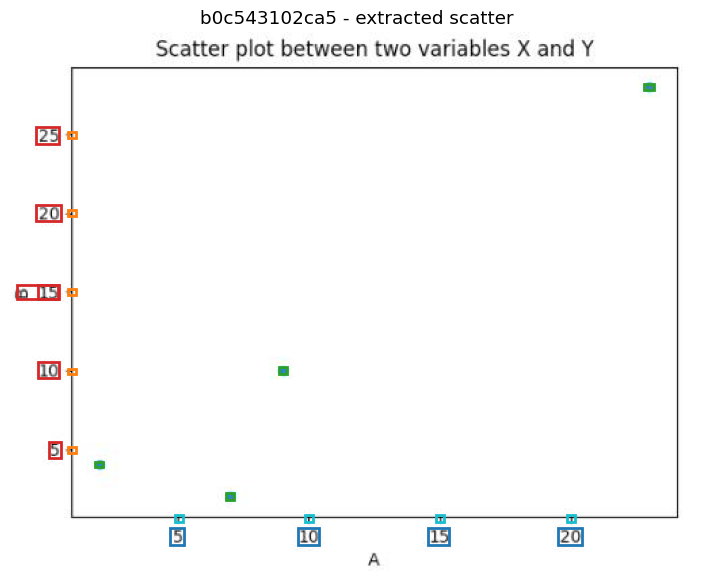

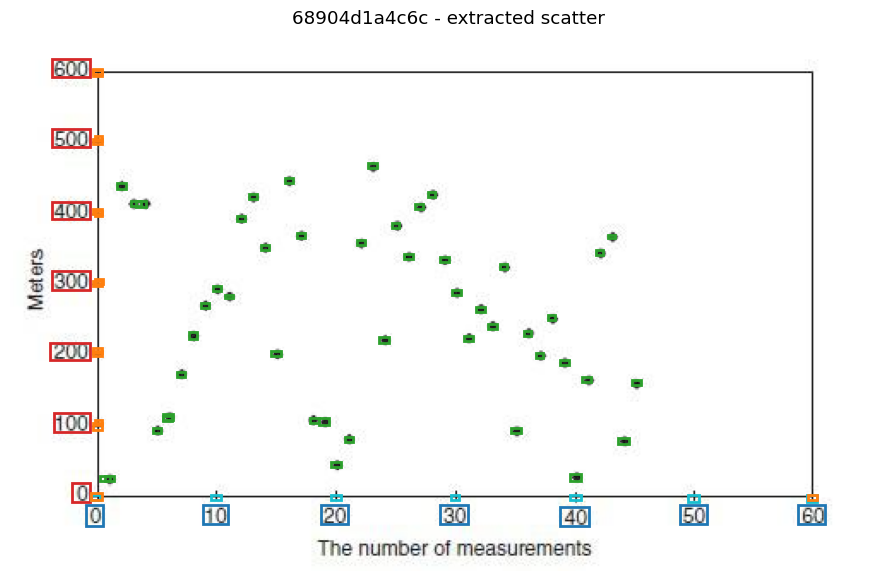

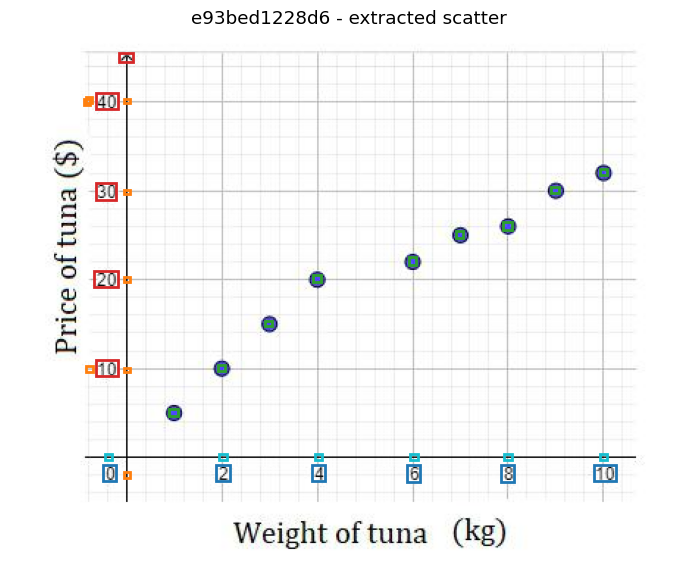

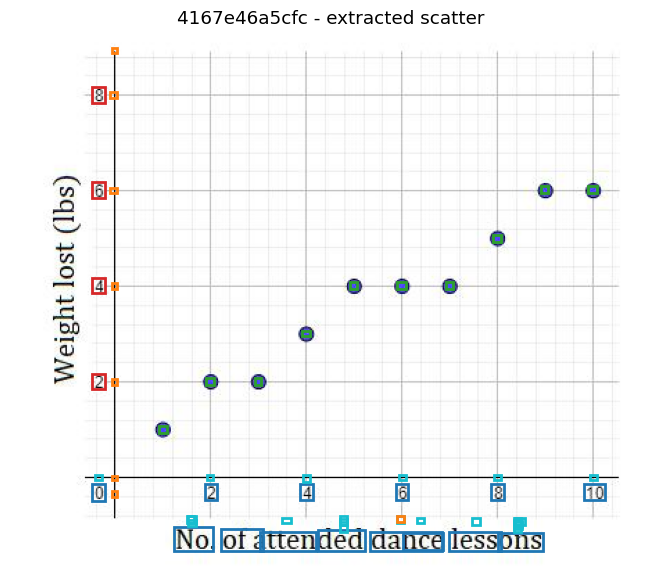

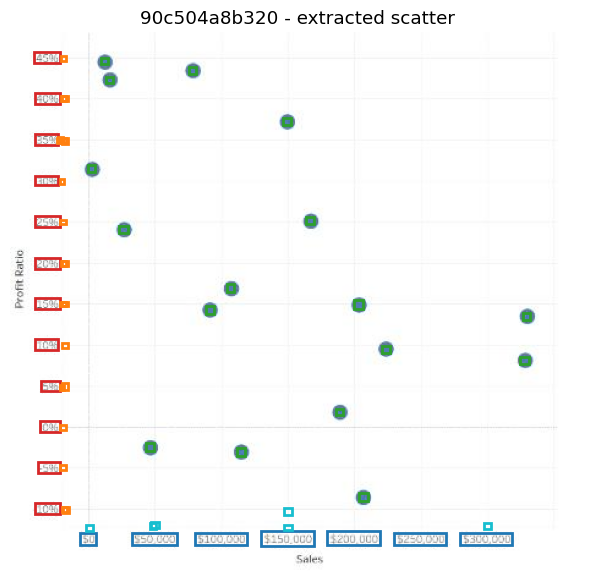

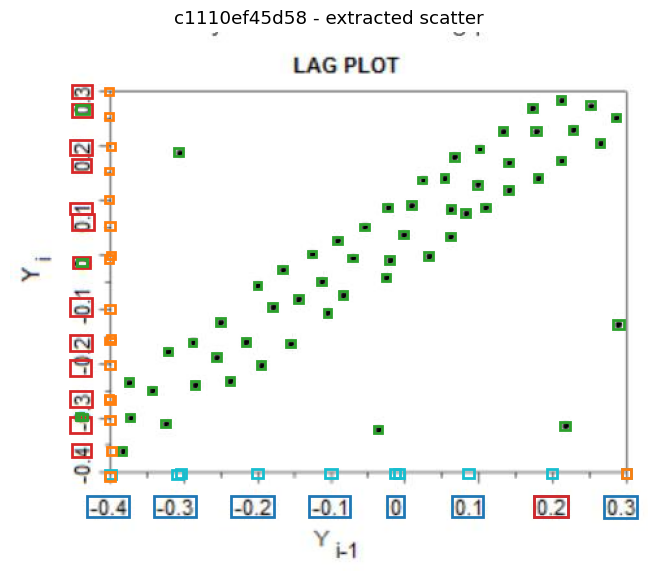

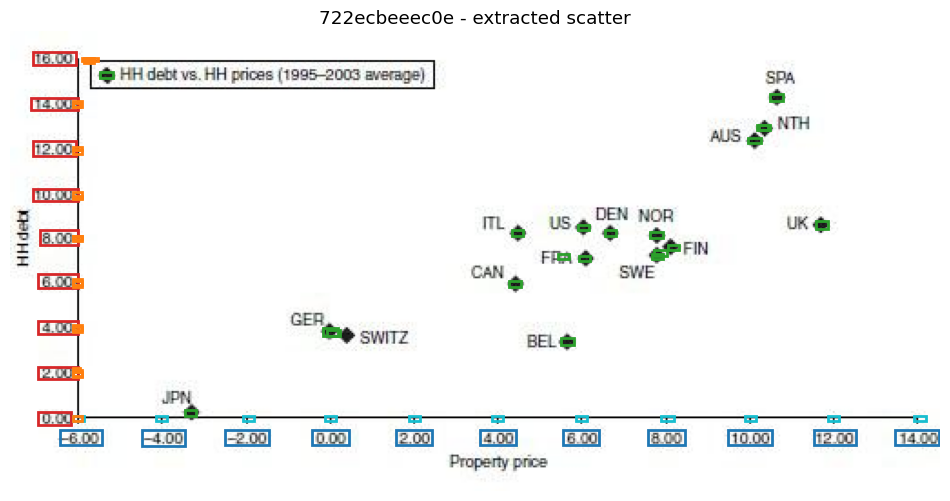

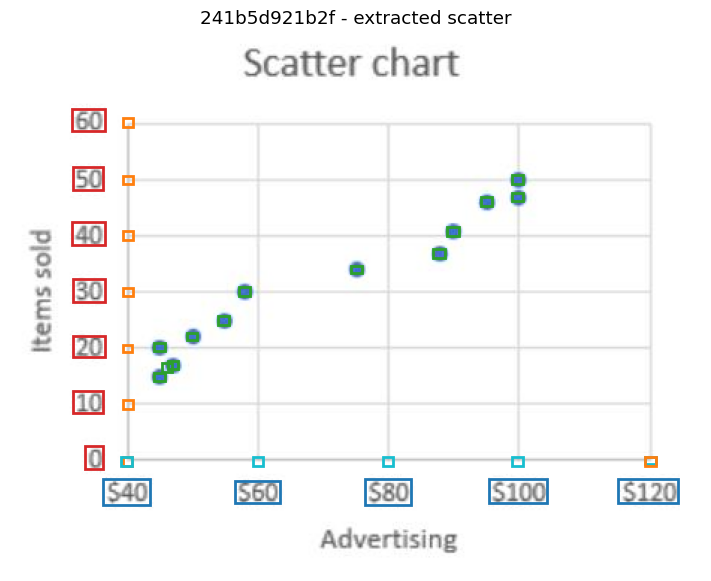

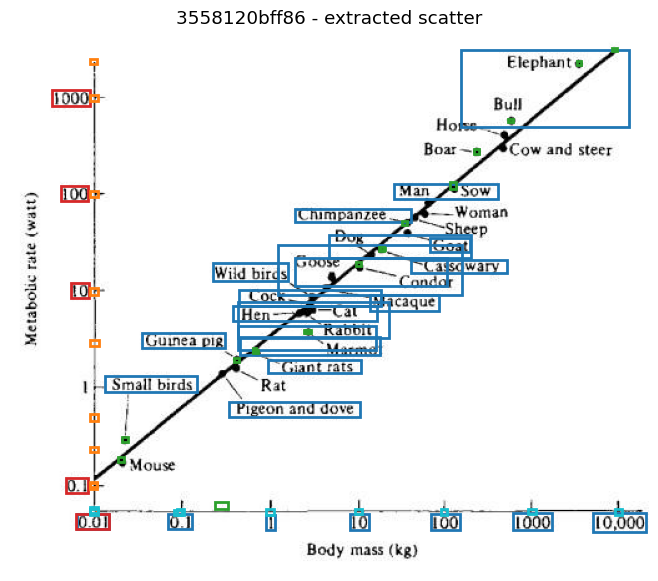

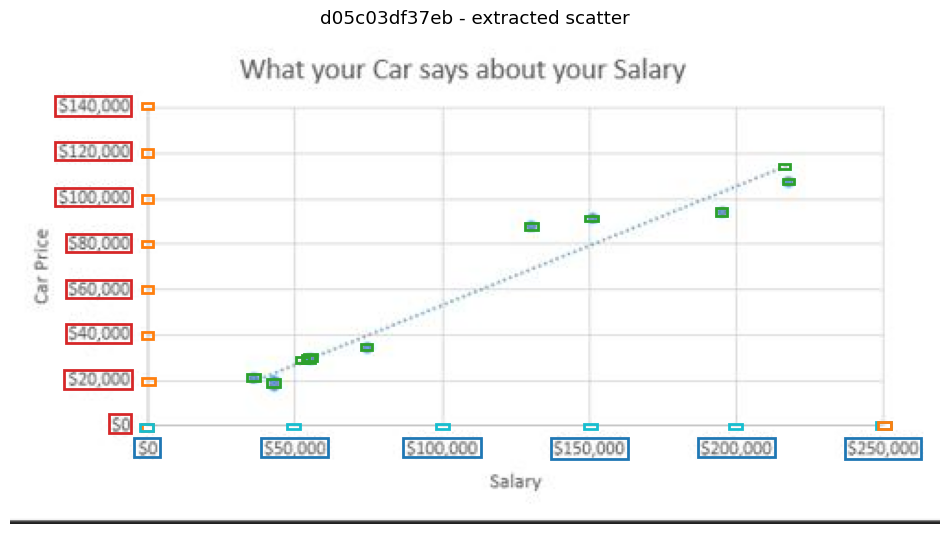

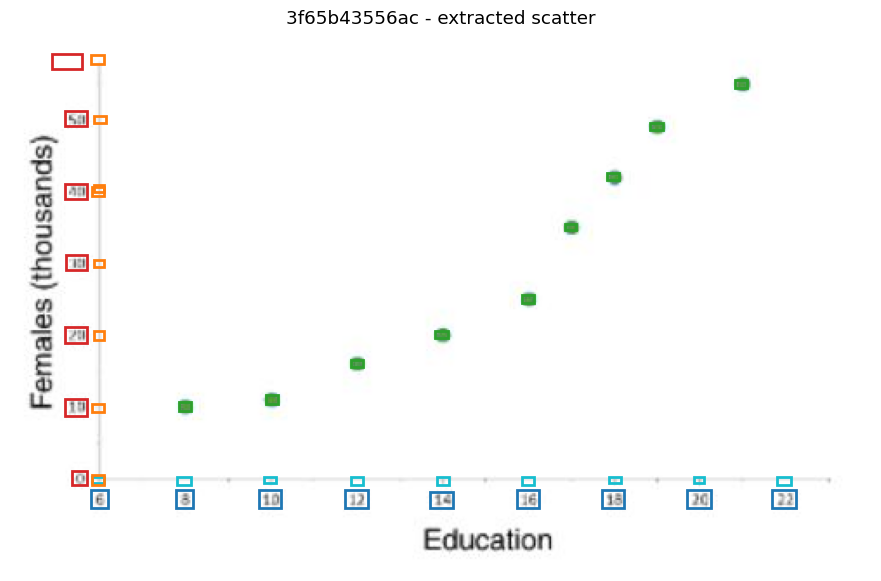

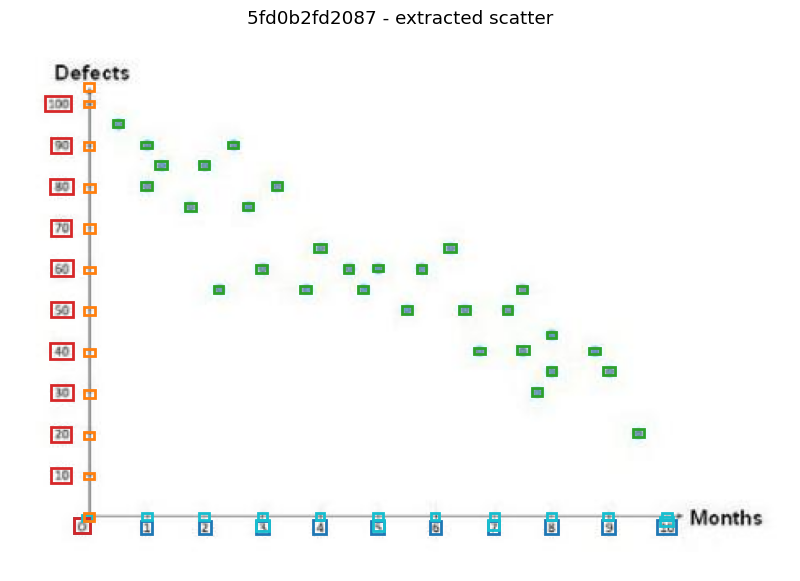

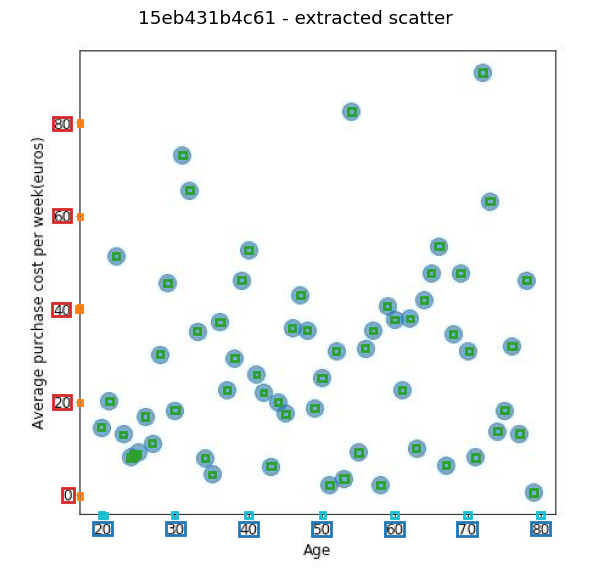

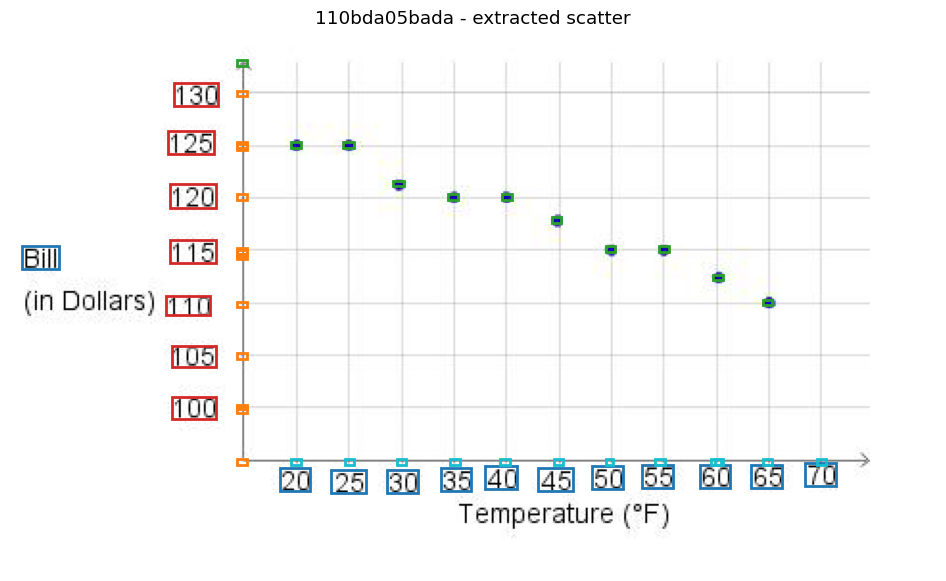

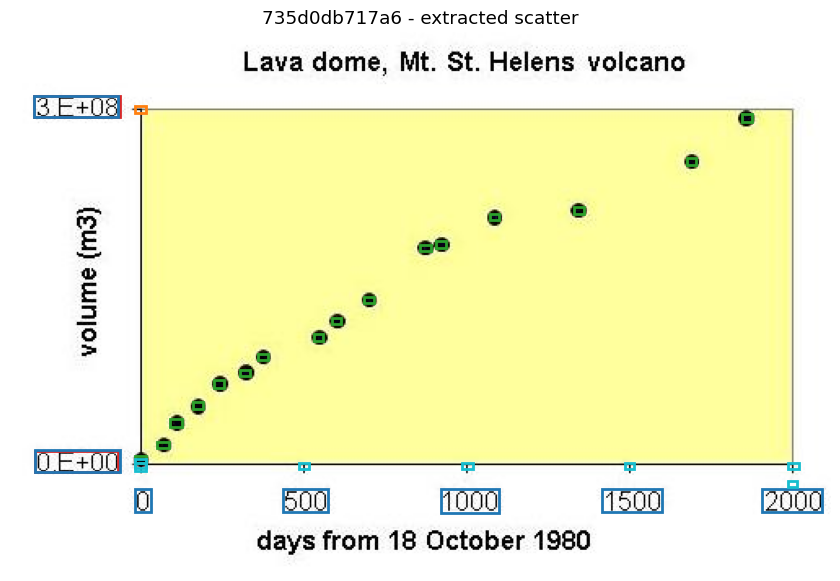

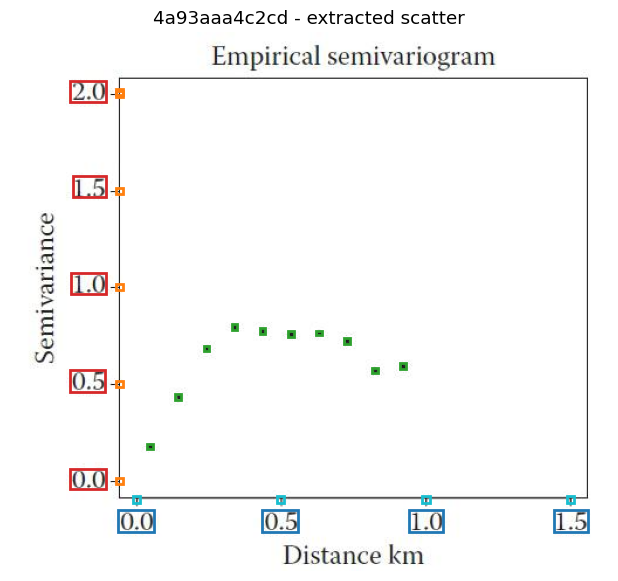

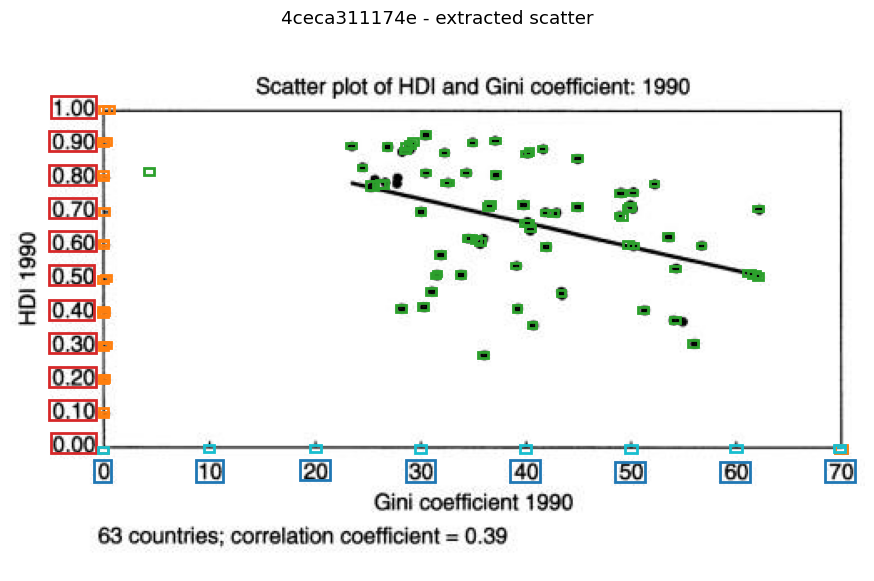

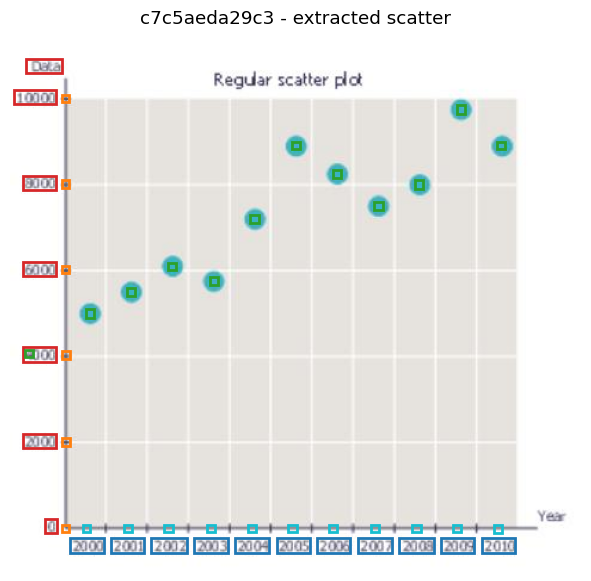

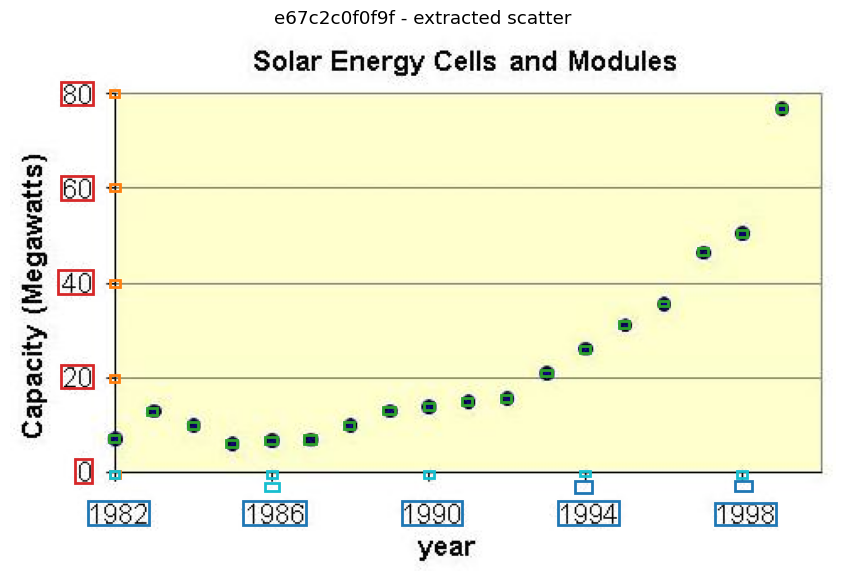

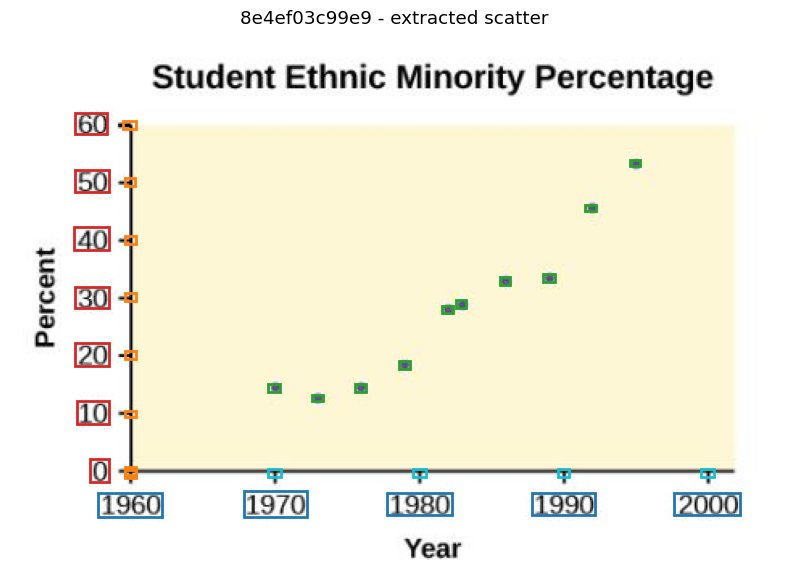

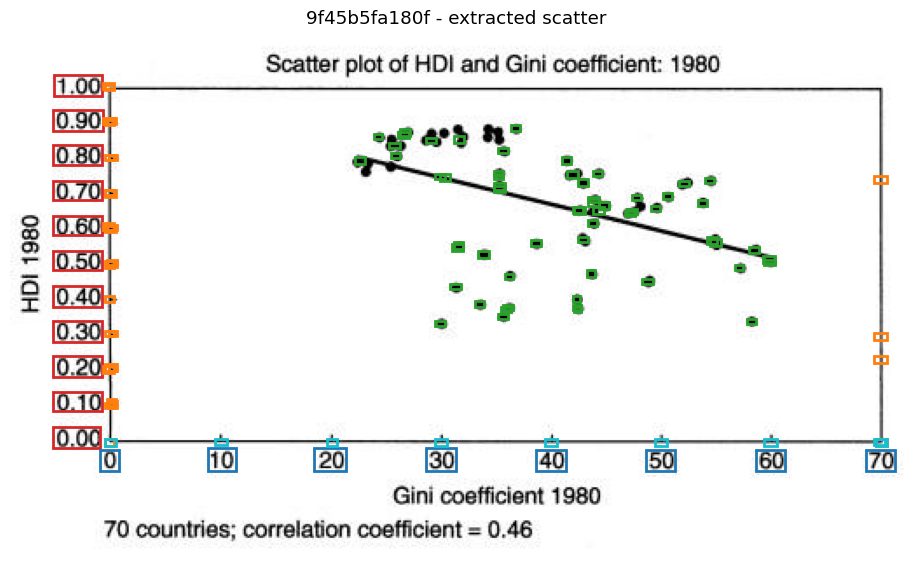

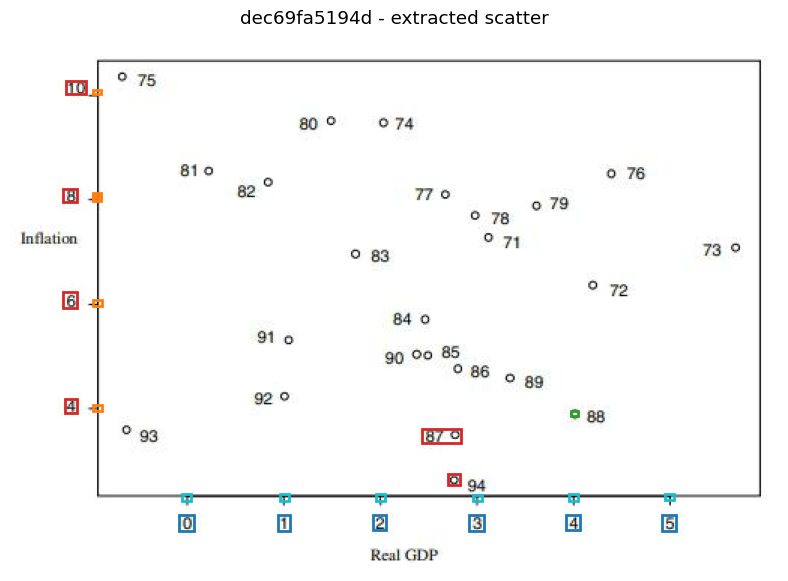

In [266]:
dataset = InferenceDataset(df_val, None)

for idx in range(len(dataset)):
    img, gt, _ = dataset[idx]

    title = f"{df_val.id[idx]} - {df_val.source[idx]} {df_val['chart-type'][idx]}"
    plot_results(img, meter.preds[idx], meter.labels[idx], figsize=(12, 7), title=title)
    
#     print('Target')
#     display(df_target[df_target['id'] == df_val.id[idx]][["x", "y"]])
    
    if idx > 20:
        break

Done ! 